In [2]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = 'datasets/dataset1/test'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_data = datasets.ImageFolder(data_dir, transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [5]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)  # Assuming 7 classes for facial expressions
model_path = 'cnn_resnet.pth'

# Load the state dictionary
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the appropriate device
model = model.to(device)

# Ensure the model is in evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# Ensure the model is in evaluation mode
model.eval()

true_labels = []
pred_labels = []

# No gradient calculation is needed
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, pred_labels)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.4371691278907774
Precision: 0.467245058077313
Recall: 0.4371691278907774
F1-Score: 0.41347938077022656


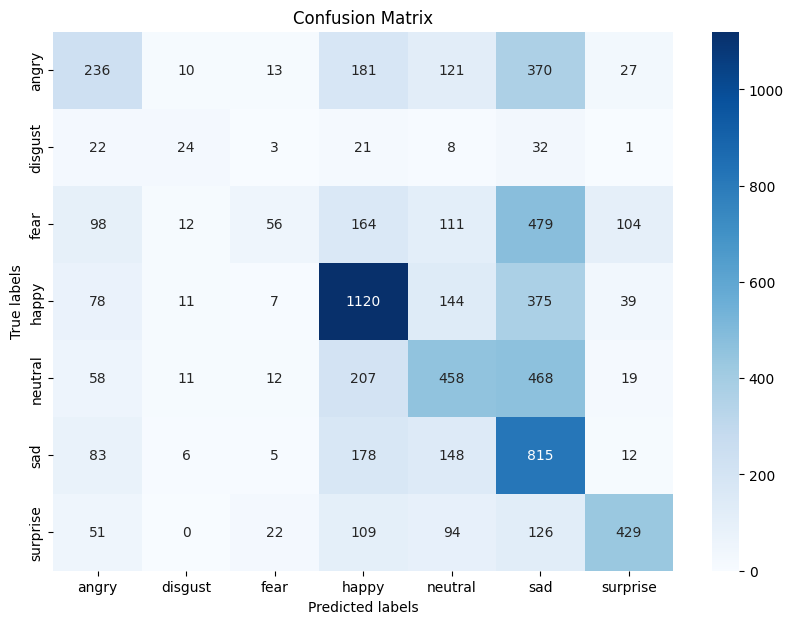

In [7]:
try:
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=test_data.classes, yticklabels=test_data.classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
except Exception as e:
    print("Failed to plot confusion matrix:", e, file=sys.stderr)